# Ataque a Redes Complexas

In [1]:
from datetime import datetime
import gzip
import json
import math
import os
import numpy as np
import pathlib
from zipfile import ZipFile
from tqdm import tqdm
from numpy import asarray
from numpy import savetxt
import pandas as pd
import mlflow

## Processa arquivos RAW extraindo dados necessários

In [2]:
path_zip = "data/31.zip"

extracao = []

# Create a ZipFile Object and load sample.zip in it
with ZipFile(path_zip, 'r') as zipObj:
  # Get a list of all archived file names from the zip
  listOfFileNames = zipObj.namelist()
  # Iterate over the file names
  count = 0
  for fileName in tqdm(listOfFileNames):
    # print(fileName)

    if "VEHICLELISTDELTA" in fileName:
      with zipObj.open(fileName) as vehicledelta:
        contents = gzip.decompress(vehicledelta.read())
        if contents:
          data_body = json.loads(contents)

          for vehicle in data_body["addedVehicles"]:
            extracao.append([vehicle["id"], data_body["timestamp"], vehicle["plate"],vehicle["geoCoordinate"]["latitude"], vehicle["geoCoordinate"]["longitude"]])


df = pd.DataFrame(extracao, columns=['id','timestamp', 'plate', 'lat', 'lon'])
df.to_csv('data/extracao.csv', index = False)

100%|██████████| 334673/334673 [00:18<00:00, 17985.29it/s]


## Pocessa arquivos para inclusão em coordenadas H3

In [3]:
!pip install h3

  Using cached h3-3.7.3-cp39-cp39-manylinux2010_x86_64.whl (806 kB)


In [4]:
import h3

for i in tqdm(range(len(extracao))):
  h3_index = h3.geo_to_h3(extracao[i][3], extracao[i][4], 9)
  h3_center = h3.h3_to_geo(h3_index) 
  # print(h3_index)
  # print(h3_center[0])
  # print(h3_center[1])
  extracao[i] = extracao[i] + [h3_index, h3_center[0], h3_center[1]]

100%|██████████| 83479/83479 [00:00<00:00, 173380.81it/s]


In [5]:
df = pd.DataFrame(extracao, columns=['id','timestamp', 'plate', 'lat', 'lon', "h3", "h3_lat", "h3_lon"])
df.to_csv('data/extracao.csv', index = False)

## Processa arquivos para inclusão de destinos

In [6]:
df.sort_values(by=["plate", "timestamp"], inplace = True)

export = df.to_numpy().tolist()

export[0] = export[0] + [export[0][5], export[0][6], export[0][7]]

for i in tqdm(range(1, len(export))):
    if export[i-1][2] == export[i][2]:
      export[i] = export[i] + [export[i-1][5], export[i-1][6], export[i-1][7]]
    else:
      export[i] = export[i] + [export[i][5], export[i][6], export[i][7]]
    
df = pd.DataFrame(export, columns=['id','timestamp', 'plate', 'lat', 'lon', "h3", "h3_lat", "h3_lon", "h3_dest", "h3_lat_dest", "h3_lon_dest"])
df.to_csv('data/extracao_grafo.csv', index = False)

100%|██████████| 83478/83478 [00:00<00:00, 577312.76it/s]


## Agrupa por origem e destino

In [7]:
# Agrupa por origem destino
grouped = df.groupby(['h3', 'h3_dest']).size().reset_index(name='counts')
selected = grouped[grouped['h3'] != grouped['h3_dest']]
selected = selected.to_numpy().tolist()
selected
for i in tqdm(range(len(selected))):
  h3_ori = h3.h3_to_geo(selected[i][0]) 
  h3_dest = h3.h3_to_geo(selected[i][1]) 
  # print(h3_index)
  # print(h3_center[0])
  # print(h3_center[1])
  selected[i] = selected[i] + [h3_ori[0], h3_ori[1], h3_dest[0], h3_dest[1]]

df_selected = pd.DataFrame(selected, columns=['h3','h3_dest', 'degree','h3_lat', 'h3_lon', "h3_dest_lat", "h3_dest_lon"])
df_selected.to_csv('data/extracao_grafo_compilado.csv', index = False)

100%|██████████| 28588/28588 [00:00<00:00, 229105.59it/s]


# Manipulação utilizando Grafos

In [8]:
import networkx as nx
G = nx.DiGraph()

plate = export[0][2]
h3_index = export[0][5]

for i in tqdm(range(1, len(export))):
    if export[i-1][2] == export[i][2]:
      G.add_edge(export[i-1][5], export[i][5])

100%|██████████| 83478/83478 [00:00<00:00, 328758.22it/s]


## Vamos analizar o nosso gráfico e retirar algumas métricas

### Coeficiênte de Custerização:

In [9]:
G_clus = nx.average_clustering(G)
G_clus

0.11843363995293066

### Diâmetro do Grafo
Repare aqui que como estamos trabalhando com um dígrafo, precisamos achar as componentes fortemente conectadas **A <--> B** para então calcular o diâmetro

In [10]:
diametros = [nx.diameter(G.subgraph(c)) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
G_dia = max(diametros)
diametros

[6, 0, 0, 0, 0]

## Grau médio do grafo

In [11]:
# Calculando o grau para cada nó
deg = G.degree()
# Transforma num DataFrame (pandas)
degree = pd.DataFrame.from_dict(data=deg)
degree.columns = ['node','degree']
degree['degree'].mean()

69.9334126040428

## Analisando se o grafo é aleatório

### O primeiro passo é encontrar o **k** que é o grau médio da rede

In [12]:
k = degree['degree'].mean()
k

69.9334126040428

\<k\> é o o grau médio de uma rede aleatória <br/>
\<k\> = p(N-1)

Seção 3.3 do Barabasi
http://networksciencebook.com/chapter/3#number-of-links

### O segundo passo é encontrar **p** que é probabilidade de dois nós estarem conectados

In [13]:
p = k/(len(G)-1)
p

0.08325406262386048

### Agora, iremos gerar um grafo aleatório direcionado utilizando esses parâmetros

In [14]:
R = nx.generators.random_graphs.erdos_renyi_graph(len(G), p, directed=True)

#### Qual o grau médio dessa rede aleatória?

In [15]:
# Calculando o grau para cada nó
Rdeg = R.degree()
# Transforma num DataFrame (pandas)
Rdegree = pd.DataFrame.from_dict(data=Rdeg)
Rdegree.columns = ['node','degree']
Rdegree['degree'].mean()

139.9833531510107

#### Qual o diâmetro?

In [16]:
R_diametros = [nx.diameter(R.subgraph(c)) for c in sorted(nx.strongly_connected_components(R), key=len, reverse=True)]
R_dia = max(R_diametros)
R_diametros

[3]

#### Qual o coeficiênte de clusterização?

In [17]:
R_clus = nx.average_clustering(R)
R_clus

0.08349295972458129

## Comparando os dois resultados

In [18]:
print("Diâmetro")
print("G: {}  R:{}".format(G_dia, R_dia))
print("Coef. de Clusterização")
print("G: {:.4f}  R:{:.4f}".format(G_clus, R_clus))

Diâmetro
G: 6  R:3
Coef. de Clusterização
G: 0.1184  R:0.0835


In [ ]:
!pip install plotly

  Using cached plotly-5.3.1-py2.py3-none-any.whl (23.9 MB)


In [ ]:
G_x = degree.sort_values(by='degree')['degree'].values
G_y = np.arange(1.0, len(G_x)+1) / len(G_x)

In [ ]:
R_x = Rdegree.sort_values(by='degree')['degree'].values
R_y = np.arange(1.0, len(R_x)+1) / len(R_x)

### ECDF e PDF dos graus de G

In [ ]:
import plotly.express as px
fig = px.scatter(x=G_x, y=G_y, marginal_x="histogram")
fig.show()

### ECDF do Grau de G e R

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=G_x, y=G_y, name='G', mode='markers'))
fig.add_trace(go.Scatter(x=R_x, y=R_y, name='R', mode='markers'))

# fig.update_yaxes(type="log")
# fig.update_xaxes(type="log")

fig.show()

## Analisando se o Grafo é Small Word

https://stats.stackexchange.com/questions/175492/how-to-test-statistically-whether-my-network-graph-is-a-small-world-network

O "estado da arte" para determinar se uma rede é small world usa a seguinte abordagem:

Calcule a média dos caminhos mais curtos L e o coeficiênte de clusterização C do grafo.

### L - média dos caminhos mais curtos

In [ ]:
L = nx.average_shortest_path_length(G)
L

### C - coeficiênte de clusterização

In [ ]:
C = nx.average_clustering(G)
C

### Gere um modelo (ou um conjunto de modelos) de grafos aleatórios, como o Erdős–Rényi ou Maslov–Sneppen

Nesse caso, usaremos o Grafo R gerado anteriormente

Calcule a média dos caminhos mais curtos Lr e o coeficiênte de clusterização Cr do grafo aleatório.

### Lr - média dos caminhos mais curtos

In [ ]:
Lr = nx.average_shortest_path_length(R)
Lr

### Cr - coeficiênte de clusterização

In [ ]:
Cr = nx.average_clustering(R)
Cr

Calcule o caminho mais curto e o coeficiente de clusterização normalizado:

$\lambda = \frac{L}{L_r}$ e $\gamma = \frac{C}{C_r}$

In [ ]:
lamb = L/Lr
lamb

In [ ]:
gamm = C/Cr
gamm

Caso $\lambda$ e $\gamma$ atenda certos critérios, o grafo G pode ser considerado small world,

por exemplo se $\lambda \approx 1$ e $\gamma > 1$

No nosso caso, $\lambda$ é $> 1$, portanto, não podemos considerar a rede small world

Podemos utilizar também o calculo de small-worldness definido por Telesford et al (2011) e Neal ZP (2017).

<br/>

Telesford QK, Joyce KE, Hayasaka S, Burdette JH, Laurienti PJ (2011). "The ubiquity of small-world networks". Brain Connectivity. 1 (5): 367–75.

Neal ZP (2017). "How small is it? Comparing indices of small worldliness". Network Science. 5 (1): 30–44.

$\sigma =  \frac{\frac{C}{C_r}}{\frac{L}{L_r}}$

Se $\sigma >1$ ($C \gg C_{r} e L \approx L_{r}$), então o grafo pode ser considerado small-world, no entanto, existem objeções a essa métrica. 

In [ ]:
sigma = gamm/lamb
sigma

### Gera um grafo regular

In [ ]:
Lat = nx.generators.random_graphs.watts_strogatz_graph(len(G),int(abs(k)), 0)

Outras medidas de small-worldness

$\omega = \frac{L_r}{L}-\frac{C}{C_l}$

Onde a média dos caminhos mais curtos L e o coeficiênte de clusterização C são claculados do grafo testado, $c_l$ é o coeficiênte de clusterização de um grafo regular equivalente Lr é o caminho mais curto médio para um grafo aleatório equivalente.

### Calculando o coeficiênte de clusterização Latice

In [ ]:
Cl = nx.average_clustering(Lat)
Ll = nx.average_shortest_path_length(Lat)

### Calculando $\omega$

In [ ]:
w = Lr/L - C/Cl
w

$SWI=\frac{L-L_\ell}{L_r-L_\ell} \times \frac{C-C_r}{C_\ell-C_r}$


Both ω′ and SWI range between 0 and 1

In [ ]:
swi = ((L-Ll)/(Lr-Ll))*((C-Cr)/(Cl-Cr))
swi

In [ ]:
# Calculando o grau para cada nó
Ldeg = Lat.degree()
# Transforma num DataFrame (pandas)
Ldegree = pd.DataFrame.from_dict(data=Ldeg)
Ldegree.columns = ['node','degree']
Ldegree['degree'].mean()

L_x = Ldegree.sort_values(by='degree')['degree'].values
L_y = np.arange(1.0, len(L_x)+1) / len(L_x)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=G_x, y=G_y, name='G', mode='markers'))
fig.add_trace(go.Scatter(x=R_x, y=R_y, name='R', mode='markers'))
fig.add_trace(go.Scatter(x=L_x, y=L_y, name='L', mode='markers'))

# fig.update_yaxes(type="log")
#fig.update_xaxes(type="log")

fig.show()

## Barabasi Albert

In [ ]:
# BA = nx.generators.random_graphs.barabasi_albert_graph(len(G), int(k), initial_graph=G, seed=200)
# BA = nx.barabasi_albert_graph(len(G), int(k), initial_graph=G, seed=200)
# BA = nx.barabasi_albert_graph(len(G), 30)
BA = nx.generators.random_graphs.barabasi_albert_graph(len(G), int(k), seed=200)

In [ ]:
# Calculando o grau para cada nó
BAdeg = BA.degree()
# Transforma num DataFrame (pandas)
BAdegree = pd.DataFrame.from_dict(data=BAdeg)
BAdegree.columns = ['node','degree']
BAdegree['degree'].mean()

BA_x = BAdegree.sort_values(by='degree')['degree'].values
BA_y = np.arange(1.0, len(BA_x)+1) / len(BA_x)

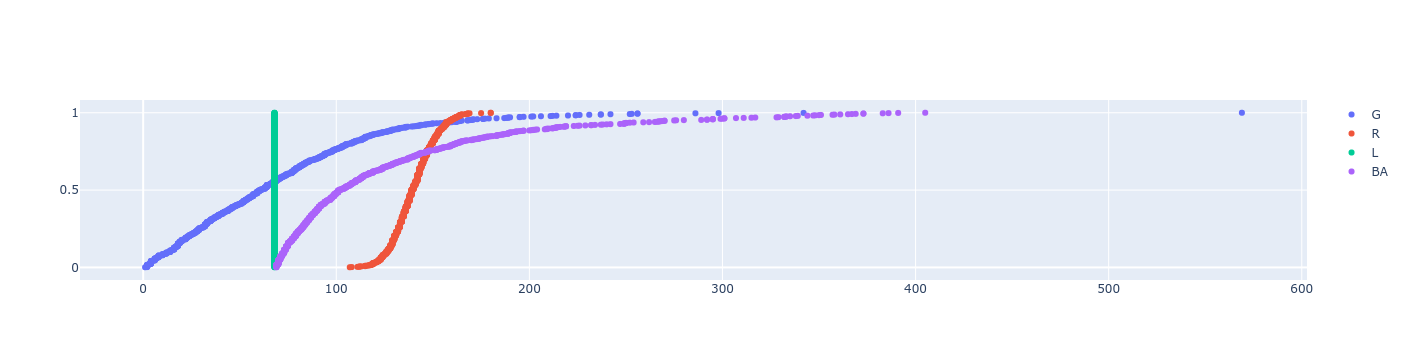

In [40]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=G_x, y=G_y, name='G', mode='markers'))
fig.add_trace(go.Scatter(x=R_x, y=R_y, name='R', mode='markers'))
fig.add_trace(go.Scatter(x=L_x, y=L_y, name='L', mode='markers'))
fig.add_trace(go.Scatter(x=BA_x, y=BA_y, name='BA', mode='markers'))

# fig.update_yaxes(type="log")
# fig.update_xaxes(type="log")

fig.show()

## O que acontece se retirarmos os nós com mais conexões?

Irei eliminer 0,5% dos nós com mais conexões, ou seja 5 nós.

In [62]:
# Calculando o grau para cada nó
deg = G.degree()
# Transforma num DataFrame (pandas)
degree = pd.DataFrame.from_dict(data=deg)
degree.columns = ['node','degree']
eliminados = degree.sort_values(by=['degree'],ascending=False)[0:5]
eliminados

,node,degree
20,891e8625bd3ffff,569
49,891e8052a37ffff,342
360,891e805052fffff,298
24,891e8050183ffff,286
33,891e8052e6bffff,256


In [70]:
Ga = G.copy()
print(len(Ga))
for index, row in eliminados.iterrows():
    Ga.remove_node(row['node'])
print(len(Ga))

841
836


In [71]:
# Calculando o grau para cada nó
dega = Ga.degree()
# Transforma num DataFrame (pandas)
degreea = pd.DataFrame.from_dict(data=dega)
degreea.columns = ['node','degree']
degreea.describe()

Ga_x = degreea.sort_values(by='degree')['degree'].values
Ga_y = np.arange(1.0, len(Ga_x)+1) / len(Ga_x)

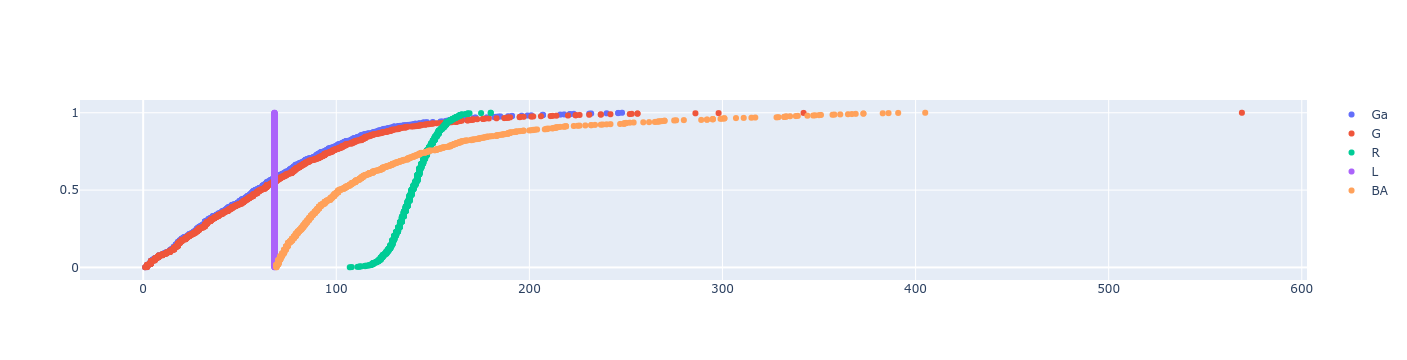

In [74]:
import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=Ga_x, y=Ga_y, name='Ga', mode='markers'))
fig.add_trace(go.Scatter(x=G_x, y=G_y, name='G', mode='markers'))
fig.add_trace(go.Scatter(x=R_x, y=R_y, name='R', mode='markers'))
fig.add_trace(go.Scatter(x=L_x, y=L_y, name='L', mode='markers'))
fig.add_trace(go.Scatter(x=BA_x, y=BA_y, name='BA', mode='markers'))

# fig.update_yaxes(type="log")
# fig.update_xaxes(type="log")

fig.show()

In [76]:
Ga_clus = nx.average_clustering(Ga)
Ga_clus

G_diametros = [nx.diameter(G.subgraph(c)) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
G_dia = max(G_diametros)
G_diametros

Ga_diametros = [nx.diameter(Ga.subgraph(c)) for c in sorted(nx.strongly_connected_components(Ga), key=len, reverse=True)]
Ga_dia = max(Ga_diametros)
Ga_diametros

print("Diâmetro")
print("Ga: {}  G:{}".format(Ga_dia, G_dia))
print("Coef. de Clusterização")
print("Ga: {:.4f}  G:{:.4f}".format(Ga_clus, G_clus))

Diâmetro
Ga: 6  G:6
Coef. de Clusterização
Ga: 0.1035  G:0.1184


## Analisando a distância média entre os nós nos dois tipos de ataques 

1 - Atacando nós com maior relevância (Degree)

2 - Atacando aleatóriamente

## 1 - Atacando nós com maior relevância (Degree)

In [88]:
Ga = G.copy()
nx.average_shortest_path_length(Ga)

2.3333658909461525

In [ ]:
# Calculando o grau para cada nó
deg = G.degree()
# Transforma num DataFrame (pandas)
degree = pd.DataFrame.from_dict(data=deg)
degree.columns = ['node','degree']
eliminados = degree.sort_values(by=['degree'],ascending=False)

Ga = G.copy()

average_dist_degree_rm_based = []

average_dist_degree_rm_based.append([0,nx.average_shortest_path_length(Ga)])
qtd_total = len(Ga)

print(len(Ga))
for index, row in eliminados.iterrows():
    Ga.remove_node(row['node'])
    try:
        insert = [(1.0-(len(Ga)/qtd_total)),nx.average_shortest_path_length(Ga)]
        print(insert)
        average_dist_degree_rm_based.append(insert)
    except Exception as e:
        print("Graph is not weakly connected: ", e)
        insert = [(1.0-(len(Ga)/qtd_total)),max([nx.average_shortest_path_length(Ga.subgraph(c)) for c in sorted(nx.strongly_connected_components(Ga), key=len, reverse=True)])]
        print(insert)
        average_dist_degree_rm_based.append(insert)

In [95]:
# Create the pandas DataFrame
average_dist_vs_removed = pd.DataFrame(average_dist_degree_rm_based, columns = ['Frac_Removed', 'avg_dist'])
average_dist_vs_removed.to_csv(r'average_dist_vs_removed.csv', index = False, header = True)
average_dist_vs_removed

,Frac_Removed,avg_dist
0,0.000000,2.333366
1,0.001189,2.356480
2,0.002378,2.363413
3,0.003567,2.368018
4,0.004756,2.373419
...,...,...
836,0.994055,0.000000
837,0.995244,0.000000
838,0.996433,0.000000
839,0.997622,0.000000


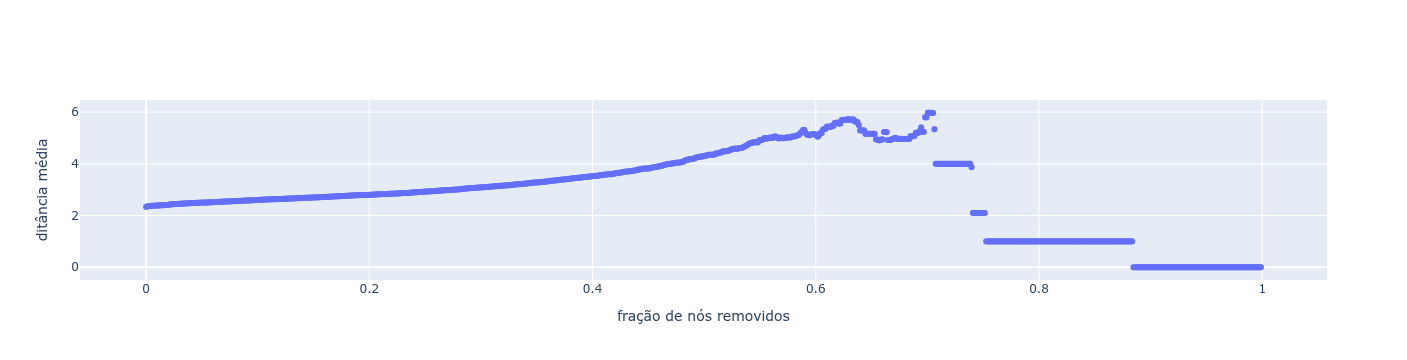

In [121]:
average_dist_vs_removed = pd.read_csv('average_dist_vs_removed.csv') 
average_dist_vs_removed_x = average_dist_vs_removed['Frac_Removed'].values
average_dist_vs_removed_y = average_dist_vs_removed['avg_dist'].values

import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=average_dist_vs_removed_x, y=average_dist_vs_removed_y, mode='markers'))

fig.update_xaxes(title_text="fração de nós removidos")
fig.update_yaxes(title_text="ditância média")

# fig.update_yaxes(type="log")
# fig.update_xaxes(type="log")

fig.show()

## 2 - Atacando aleatóriamente

In [ ]:
from random import choice

Gr = G.copy()

average_dist_degree_rm_based_rand = []

average_dist_degree_rm_based_rand.append([0,nx.average_shortest_path_length(Gr)])
qtd_total = len(Gr)


while len(Gr) > 0:
    Gr.remove_node(choice(list(Gr.nodes())))
    try:
        insert = [(1.0-(len(Gr)/qtd_total)),nx.average_shortest_path_length(Gr)]
        print(insert)
        average_dist_degree_rm_based_rand.append(insert)
    except Exception as e:
        print(e)
        insert = [(1.0-(len(Gr)/qtd_total)),max([nx.average_shortest_path_length(Gr.subgraph(c)) for c in sorted(nx.strongly_connected_components(Gr), key=len, reverse=True)])]
        print(insert)
        average_dist_degree_rm_based_rand.append(insert)

In [119]:
# Create the pandas DataFrame
average_dist_vs_removed_rand = pd.DataFrame(average_dist_degree_rm_based_rand, columns = ['Frac_Removed', 'avg_dist'])
average_dist_vs_removed_rand.to_csv(r'average_dist_vs_removed_rand.csv', index = False, header = True)
average_dist_vs_removed_rand

,Frac_Removed,avg_dist
0,0.000000,2.333366
1,0.001189,2.336007
2,0.002378,2.336019
3,0.003567,2.337130
4,0.004756,2.337624
...,...,...
836,0.994055,0.000000
837,0.995244,0.000000
838,0.996433,0.000000
839,0.997622,0.000000


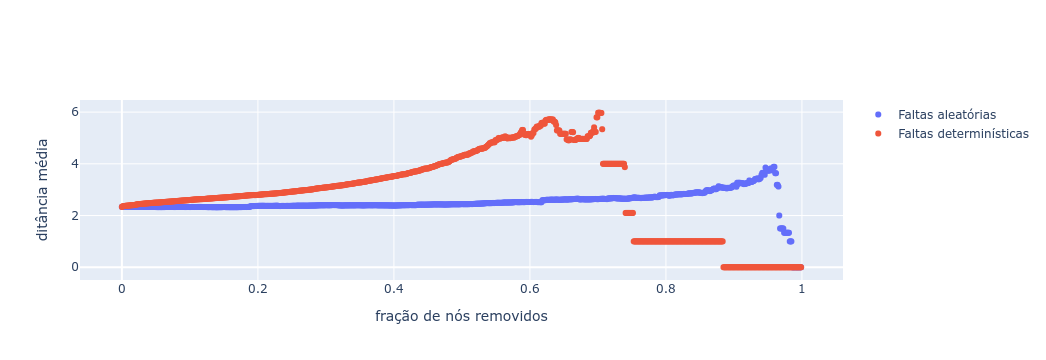

In [127]:
average_dist_vs_removed_rand = pd.read_csv('average_dist_vs_removed_rand.csv') 
average_dist_vs_removed_rand_x = average_dist_vs_removed_rand['Frac_Removed'].values
average_dist_vs_removed_rand_y = average_dist_vs_removed_rand['avg_dist'].values

import plotly.graph_objects as go
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=average_dist_vs_removed_rand_x, y=average_dist_vs_removed_rand_y, name="Faltas aleatórias", mode='markers'))
fig.add_trace(go.Scatter(x=average_dist_vs_removed_x, y=average_dist_vs_removed_y, name="Faltas determinísticas", mode='markers'))

fig.update_xaxes(title_text="fração de nós removidos")
fig.update_yaxes(title_text="ditância média")

# fig.update_yaxes(type="log")
# fig.update_xaxes(type="log")

fig.show()

Analisando o gráfico da variação da distância média da fração de nós removidos, podemos concluir que o grafo analisado tem alta robustez, a distância média sofreu pouca variação, tanto no caso de faltas aleatórias, quanto no caso de faltas determiníscas (ordenadas pelo grau). 

Observe que para o caso de faltas determiníscas, removendo 5% dos nós com maior grau da rede, a distância média entre os nós aumentou de 2.33 para 2.49, ou seja 6.4%. 

Em um modelo BA o impacto da remoção determinística de nós causa uma diferença na distância média muito maior. O que nos evidencia que o Grafo estudado se aproxima mais de um modelo small-world.